# Basics of Forecasting

**Approximate Learning time:** Up to 1 hour

--- 

In this module, we will formally define forecasting, discuss the metrics used to evaluate forecasting methods, and explain how datasets are split for developing forecasting models. Lastly, we will also learn how to leverage GluonTS to split data.

---

## Formal Definition

Consider a time series denoted by $\{x_t\}_{t=0}^T = \{x_0, x_1, x_2, \dots, x_T\}$. The task of forecasting involves predicting future time steps at $T+1$, $T+2$, $\dots$, $T+H$, where $H$ is the forecasting horizon. We denote these predictions as $\{\hat{x}_{T+i}\}_{i=1}^{H}$.

A forecasting model is designed to accomplish the following task:

$$
\{\hat{x}_{T+i}\}_{i=1}^{H} = f_{\theta}(\{x_t\}_{t=0}^T)
$$

Here, $f_\theta$ represents a family of models defined by parameters $\theta$. The task of modeling is to find the parameter values corresponding to the best "fit." Each modeling task has its own criterion for what constitutes a good fit, which we will learn about in future modules.

The best parameter values are found by solving the following:

$$
\theta^* = \arg\max \text{Fit}(\{\hat{x}_{T+i}\}_{i=1}^{H}, \{x_{T+i}\}_{i=1}^{H})
$$

Here, $\arg\max$ indicates that the parameters $\theta$ that maximize the value of Fit are to be returned.

---

## Evaluation Metrics

The definition of "fit" often depends on the specific modeling task. However, after learning the best parameters, the task moves to performing inference or deploying the model in real-world scenarios. How well a model performs in these real-world applications is typically captured by metrics not directly optimized during model training, mainly due to the difficulty in modeling them explicitly. These metrics are crucial for determining the actual performance of the model. In this section, we will discuss the key evaluation metrics for time series forecasting models. 

Assume we have a time series of total length $T$ and a forecasting horizon of $H$. We will also assume that ground truth values for the forecasting horizon, i.e., $\{x_{T+i}\}_{i=1}^H$, are available.

1. **Mean Absolute Error (MAE)**: MAE measures the average magnitude of errors in the predictions, ignoring direction. It provides an easily interpretable linear scale of errors.

$$
     \text{MAE} = \frac{1}{F} \sum_{k=1}^{F} |\hat{x}_{T+k} - x_{T+k}|
$$

2. **Mean Squared Error (MSE)**: MSE penalizes larger errors by squaring the differences, making it especially useful when large errors are particularly undesirable.

$$
     \text{MSE} = \frac{1}{F} \sum_{k=1}^{F} (\hat{x}_{T+k} - x_{T+k})^2
$$

3. **Root Mean Squared Error (RMSE)**: RMSE is the square root of MSE, bringing the error back to the original units of the data, which makes it more interpretable.

$$
     \text{RMSE} = \sqrt{\frac{1}{F} \sum_{k=1}^{F} (\hat{x}_{T+k} - x_{T+k})^2}
$$

4. **Mean Absolute Scaled Error (MASE)**: MASE scales the MAE relative to a naive model, which helps compare performance across different datasets. This makes MASE independent of the data’s scale, providing a baseline context for model performance.

A naive MAE is defined over historical data, not the forecasting period. Typically, the lag-1 observation is used as the forecast for the next time step, or the last seasonal observation is used if seasonality exists in the data.

$$
     \text{MASE} = \frac{\text{MAE}}{\text{MAE}_{\text{naive}}}
$$

The naive MAE is computed as:

$$
\text{MAE}_{\text{naive}} = \frac{1}{T - 1}\sum_{t=2}^{T} \mid x_{t - 1} - x_{t} \mid
$$

Thus, MASE becomes:

$$
     \text{MASE} = \frac{\frac{1}{F}\sum_{k=1}^{F} |\hat{x}_{T+k} - x_{T+k}|}{\frac{1}{T - 1}\sum_{t=2}^{T} \mid x_{t - 1} - x_{t} \mid}
$$

- MASE is particularly useful because it allows for comparisons across different datasets and is not affected by the scale of the data. This makes it ideal for benchmarks and comparing different forecasting models.
  
- When choosing evaluation metrics, it’s essential to consider the characteristics of your data and the specific requirements of your forecasting problem to ensure you're using the most appropriate metric(s).

**Note:** We will be using the MASE metric to evaluate our forecasting methods. It is recommended to spend some time understanding this metric thoroughly.

--- 

There are helper functions for the above metrics in `utils.py`. Let's look at a rough example of how to use the MASE metric. You are encouraged to read the code in `utils.py` to understand how these metrics work. 

For illustration, we will use `m4` dataset in this tutorial, assume that $H$ time steps are to be predicted, and the data before the last $H$ observations, 
is used as the data to build the forecasting model. We will also assume a very simple forecast model that outputs the mean on the train data for all the future steps. 

In [3]:
import pathlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import sys; sys.path.append("../")
import utils_tfb
import utils

TS_DATA_FOLDER = pathlib.Path("../forecasting").resolve() # Data folder

dataset_name = "m4_monthly_dataset_43531.csv"
dataset = TS_DATA_FOLDER / dataset_name
data = utils_tfb.read_data(dataset)
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (199, 1)


,channel_1
date,
1998-12-31 12:00:00,4155.7457
1999-01-31 12:00:00,4291.8389
1999-02-28 12:00:00,4168.7291
1999-03-31 12:00:00,4470.3329
1999-04-30 12:00:00,4710.2099


Text(0.5, 1.0, 'MASE:  3.271')

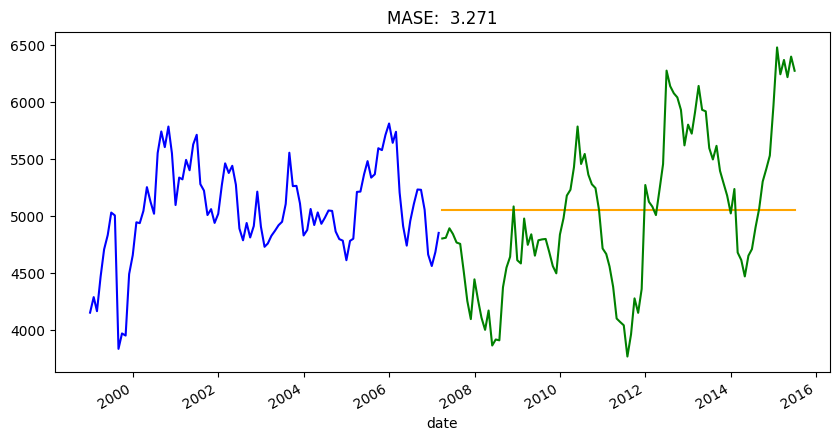

In [4]:
H = 100

# data
train_data = data['channel_1'][:-H]
test_data = data['channel_1'][-H:]

# forecast model
forecast = pd.Series(np.ones_like(test_data) * train_data.mean(), index=test_data.index)

# compute metric
mase = utils.mean_absolute_scaled_error(forecast, test_data.values, train_data.values)

# plot
fig, ax = plt.subplots(figsize=(10,5), dpi=100)
train_data.plot(ax=ax, color='blue')
forecast.plot(ax=ax, color='orange')
test_data.plot(ax=ax, color='green')
ax.set_title(f"MASE: {mase: 0.3f}")



**Exercise**: Can you think of other simpler ways to have a better fit, i.e., to reduce the MASE metric? Make sure that you only use `train_data` to base your predictions. 

---

## Dataset Splitting for Time Series

To build any forecasting model, we typically need at least two subsets from the original dataset: (a) a **training set** and (b) a **test set**. The test set is separated at the beginning and kept aside to ensure that no information from it leaks into the model development process. The test data represents unseen future data, enabling us to properly evaluate the model's performance in real-world scenarios.

Let’s denote the time series as $\{x_t\}_{t=0}^{T}$, where $t$ represents time. Suppose we use the data up to time $t_T$ for training, and let $t_{test} > t_T$ denote the end point of the test data. The train and test sets can be roughly represented as:

$$
\mathcal{D}_{train} = \{x_0, x_1, \dots, x_{t_{T}}\}
$$

$$
\mathcal{D}_{test} = \{x_{t_{T}+1}, x_{t_{T}+2}, \dots, x_{t_{test}}\}
$$

**Note:** None of the observations from $\mathcal{D}_{test}$ should be used for model building, therefore it is only used at the very end of the modelling process to evaluate the model's performance. 

### Training, Validation, and Test Splits

While training a model on $\mathcal{D}_{train}$, some modeling approaches further divide the training data into (a) a **training subset** and (b) a **validation subset**. The validation set is used to tune hyperparameters that cannot be directly optimized by the learning algorithm. Let $t_{train} < t_{val} < t_{test}$, then we can define the training, validation, and test sets as follows:

- The training set:
$$
\mathcal{D}_{train} = \{x_0, x_1, \dots, x_{t_{train}}\}
$$

- The validation set:
$$
\mathcal{D}_{validation} = \{x_{t_{train}+1}, \dots, x_{t_{val`}}\}
$$

- The test set:
$$
\mathcal{D}_{test} = \{x_{t_{val}+1}, \dots, x_{t_{test}}\}
$$

### Approaches to Time Series Splitting for Modeling

How time series data is used as input varies significantly between different modeling approaches. Figure 1 illustrates three common strategies that forecasting models use to leverage training data.

<div style="text-align: center; padding: 20px;">
<img src='./images/io.png' width="750px" style="max-width: 70%; clip-path: inset(2px); height: auto; border-radius: 15px; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.1); "></img>
</div>


#### Fixed Window Approach (Figure 1A)
In this strategy, the entire **$\mathcal{D}_{train}$** is used for model building. Once the model is trained, its predictions beyond the training dataset are used to evaluate its performance on the validation set. This approach, often referred to as the **fixed window** method, is commonly used in classical modeling approaches (Module 3) as well as in cases where forecasting is treated as a supervised learning task (Module 4). The specific way the dataset is sliced into inputs can vary depending on the modeling approach.


#### Sliding Window Approach (Figure 1B)
In the **sliding window** approach, the input to the model is a fixed-size window of past observations that "slides" forward through time. This approach is useful for models that have a fixed number of inputs, such as many machine learning models (e.g., MLP) that require a fixed input size. It is also advantageous when using the entirety of past observations as input is impractical due to computational constraints.

For a sliding window of length $L$, the dataset at time $t$ would be:
$$
\text{Input}(t) = \{x_{t-L}, x_{t-L+1}, \dots, x_{t}\}
$$

$$
\text{Target}(t) = \{x_{t+1}, x_{t+2}, \dots, x_{t+H}\}
$$ 

#### Expanding Window Approach (Figure 1C)
The **expanding window** approach involves using an increasing amount of data as time progresses. This method is well-suited for models that can handle variable input sizes, such as deep learning models that operate on sequential data.

At each time step $t$, the training set is:
$$
\text{Input}(t) = \{x_0, x_1, \dots, x_{t}\}
$$

$$
\text{Target}(t) = \{x_{t+1}, x_{t+2}, \dots, x_{t+H}\}
$$

Here, the window expands as more data becomes available, allowing the model to use all past data for training. This method is often used when the total amount of training data is not large.

### Refitting to Train & Val datasets

It is common practice to refit the model using the best-found hyperparameters on both the training and validation datasets before establishing the test metrics. This is done because, in practice, one should leverage the maximum number of observations available to make more accurate future predictions.


---

## GluonTS for Dataset Splitting


We will be using GluonTS in **Module 6**, so it's worthwhile to explore how GluonTS handles data splitting.

Specifically, we will implement the **sliding window** approach for data splitting. Let's assume `FORECASTING_HORIZON` represents the maximum number of steps we need to predict in the future. Since we have a pandas DataFrame, we can use GluonTS's **`PandasDataset`** to ensure it contains the necessary attributes that GluonTS requires for preprocessing and splitting.

The configuration for splitting is specified in the **`InstanceSplitter`** ([documentation](https://ts.gluon.ai/stable/api/gluonts/gluonts.transform.html?highlight=instancesplitter#gluonts.transform.InstanceSplitter)), which is applied to the GluonTS dataset. 

In [5]:
from gluonts.dataset.pandas import PandasDataset
FORECASTING_HORIZON = H = 10
SEQUENCE_LENGTH = L = 50

train_data = data.iloc[:-FORECASTING_HORIZON]
gluon_train_data = PandasDataset(train_data, target=data.columns)
print(f"Number of steps in training data: {len(train_data)}")
gluon_train_data


Number of steps in training data: 189


/Users/gupta/Workspace/tutorials/time_series_v3/forecasting/lib/python3.11/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


PandasDataset<size=1, freq=M, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [6]:
# Transformations from Module 1/Notebook 1.3
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.dataset.field_names import FieldName # Offers a mapping from attributes to string names 
from gluonts.transform import (
    AddAgeFeature,
    AddTimeFeatures, 
    Chain,
    RemoveFields,
    RenameFields,
    AsNumpyArray,
    VstackFeatures,
)

remove_field_names=[FieldName.FEAT_STATIC_REAL, FieldName.FEAT_DYNAMIC_REAL, FieldName.FEAT_STATIC_CAT]
transformation = Chain(
    [RemoveFields(field_names=remove_field_names)]
    + [
        AsNumpyArray(
            field=FieldName.TARGET,
            expected_ndim=2,
        ),
        AddTimeFeatures(
            start_field=FieldName.START,
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_TIME,
            time_features=time_features_from_frequency_str('M'),
            pred_length=24,
        ),
        AddAgeFeature(
            target_field=FieldName.TARGET,
            output_field=FieldName.FEAT_AGE,
            pred_length=24,
            log_scale=True,
        ),
        VstackFeatures(
            output_field=FieldName.FEAT_TIME,
            input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
        ),
        RenameFields(
            mapping={
                FieldName.FEAT_TIME: "time_features",
                FieldName.TARGET: "values",
            }
        )
    ]
)
transformed_data = transformation.apply(gluon_train_data, is_train=True)

In [7]:
# Data splitters from GluonTS
from gluonts.transform import InstanceSplitter, NumInstanceSampler

# define the splitter's configuration 
instance_splitter = InstanceSplitter(
    target_field="values", # target time series will be split into past and future values (see the keys of resulting instances)
    is_pad_field=FieldName.IS_PAD, # when there is not sufficient past history in the input data, it fills it up with PAD values (read below)
    start_field=FieldName.START, # denotes the field that holds the start date
    forecast_start_field=FieldName.FORECAST_START, # similar to start date but for the time step that indicates the starting of forecast 
    instance_sampler=NumInstanceSampler(N=11, min_future=FORECASTING_HORIZON), # N indicates number of indices to sample, we should expect a total of N instances
    past_length=SEQUENCE_LENGTH , # number of time steps in the input
    future_length=FORECASTING_HORIZON, # number of time steps in the target 
    time_series_fields=["time_features"], # other features will be split accordingly, specify their names here
)

# apply the above configuration to the data
training_instances = instance_splitter.apply(transformed_data) 

for instance in training_instances:
    # print(instance)
    break


print(f"Number of instances: {len(training_instances)}")
print(f"Shape of inputs (past_values): {instance['past_values'].shape}")
print(f"Shape of target values (future_values): {instance['future_values'].shape}")
print("Keys in the instance", instance.keys())
print("Start field: ", instance['start'])
print("Forecast start field: ", instance['forecast_start'])

Number of instances: 11
Shape of inputs (past_values): (50, 1)
Shape of target values (future_values): (10, 1)
Keys in the instance dict_keys(['start', 'past_time_features', 'future_time_features', 'past_values', 'future_values', 'past_is_pad', 'forecast_start'])
Start field:  1998-12
Forecast start field:  2006-02


The above method is the simplest way to split a dataset into instances. 

Note that the field `past_is_pad` holds values of 1 or 0. A value of 1 indicates that the corresponding `past_values` are not observed. This occurs when the index sampled by `NumInstanceSampler` doesn't have enough values to meet the required `SEQUENCE_LENGTH`. In such cases, the sampler outputs as many values as it can and pads the rest on the left with 1s. The modeling approach should handle this padding when building the model to ensure proper utilization of the data. By padding, you maximize the use of available data. The alternative is to discard such samples, which reduces the overall amount of training data.

A more advanced version of this splitting technique will be introduced in Module 6, where we will train an Informer model.

---

## Conclusion

We established a formal definition of forecasting, learned about various metrics that are used to evaluate forecasting methods, developed intuition around data splitting for modeling. Finally, we learned how to use GluonTS for splitting time series datasets.

--- 

## Next Steps


Starting from the next module, we will dive into forecasting methods. In Module 3/Notebook 3.1, we will introduce a single dataset, transform it, and use it throughout the upcoming modules to build forecasting models. Module 3/Notebook 3.2 begins with classical models like ARIMA, while Module 4 and beyond focus on machine learning approaches. There are no strict dependencies between the modules, so feel free to skip to any module of interest.

---